In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from ConvLSTM import ConvLSTM
from ConvLSTMDataset import StormDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data Preprocessing
### Dataset
During the data preprocessing process, I inherited the Dataset class from PyTorch and loaded images into memory based on the storm's name.Considering that I will be using an LSTM network to process the data, I have decided to perform pixel equalization on the images, reduce their dimensions, and convert each image to grayscale.
### Datasplit
During training, I set aside 20% of the images as a test set and used the preceding 80% of the data for training, considering the temporal sequence.
</br>**I have implemented my StormDataset class in ConvLSTMDataset file**

In [12]:
from torch.utils.data import Subset

stormdata = StormDataset('/content/drive/MyDrive/ACS2/Selected_Storms_curated/','bkh',8, time_gap=1)
train_size = int(0.8*len(stormdata))
storm_train = Subset(stormdata, range(train_size))
storm_test= Subset(stormdata, range(train_size,len(stormdata)))

## Model Selection
When selecting the model, I took into consideration the high temporal correlation between the target images and the preceding images for this task. Therefore, I chose to use an LSTM network as a crucial component of the model. Additionally, I needed to employ a convolutional neural network (CNN) to extract feature information from the images. In terms of the detailed architecture of the model, I have made the following attempts:
- The combination of a regular CNN and an LSTM network is employed, followed by fully connected layers and deconvolutional layers to transform the output of the LSTM network back into images. However, this approach tends to produce very similar images between consecutive time steps and does not exhibit variations over time.
- Using only a convolutional neural network, I take the images from i to i+sequence_length-1 as input and aim to predict the image at i+sequence as the output. However, a drawback of this model is that it loses a significant amount of temporal information during training.
- Combining Convolutional LSTM with a convolutional neural network, where the Convolutional LSTM is inspired by the following paper: https://arxiv.org/pdf/1506.04214.pdf. This network architecture was my final choice as it effectively preserves both image and temporal information.

In [4]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # First pooling layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # Remove the second pooling layer, and use a convolution with stride 2 to reduce feature map size
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # Remove the third pooling layer
        )

    def forward(self, x):
        return self.conv_layers(x)

class CNNLSTMModel(nn.Module):
    def __init__(self):
        super(CNNLSTMModel, self).__init__()
        self.encoder = SimpleCNN()

        # Assuming the output of SimpleCNN is a 128-dimensional feature map
        self.conv_lstm = ConvLSTM(input_dim=128, hidden_dim=[64, 64, 64], kernel_size=(3, 3), num_layers=3, batch_first=True)

        # Decoder
        self.decoder = nn.Sequential(
            # First transpose convolution, upsampling the feature map by a factor of 2
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            # Second transpose convolution, further upsampling the feature map by a factor of 2
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            # Optional: additional layers to increase model complexity
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # Final layer, restoring the original number of channels
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # Assuming the output image is normalized within the range [-1, 1]
        )

    def forward(self, input_imgs):
        batch_size, seq_len, c, h, w = input_imgs.size()
        c_in = input_imgs.view(batch_size * seq_len, c, h, w)
        c_out = self.encoder(c_in)

        # Adjust the shape for ConvLSTM
        c_out = c_out.view(batch_size, seq_len, -1, h // 4, w // 4)  # Adjusted for the MaxPool layers

        # ConvLSTM processing
        conv_lstm_out, _ = self.conv_lstm(c_out)
        conv_lstm_out = conv_lstm_out[0][:, -1, :, :, :]  # Use the output of the last time step

        # Generate the predicted image
        output_image = self.decoder(conv_lstm_out)
        return output_image



## Training strategy
### Loss Function
In the choice of the loss function, I opted for SSIM. Compared to other loss functions, SSIM can better measure the similarity between two images as perceived by the human eye.
### Data volume.
We once attempted to train the model on a single storm dataset alone. However, the model failed to capture the finer details of the images, resulting in very blurry generated images. Therefore, we trained our model on multiple datasets.
### Train Loop
During training, I opted for a time step of 8, a batch size of 32, and employed a strategy of training for 100 epochs on each storm dataset.

In [5]:
def gaussian_window(size, sigma):
    coords = torch.arange(size, dtype=torch.float32) - size // 2
    grid = torch.exp(-(coords ** 2) / (2 * sigma ** 2))
    grid /= grid.sum()
    return grid.view(1, -1) * grid.view(-1, 1)

def ssim(img1, img2, window_size=11, window_sigma=1.5, size_average=True):
    channel = img1.size(1)
    window = gaussian_window(window_size, window_sigma).to(img1.device).repeat(channel, 1, 1, 1)

    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIMLoss(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIMLoss, self).__init__()
        self.window_size = window_size
        self.size_average = size_average

    def forward(self, img1, img2):
        return 1 - ssim(img1, img2, self.window_size, size_average=self.size_average)



In [ ]:
from torch.utils.data import DataLoader

dataset1 = StormDataset('/content/drive/MyDrive/Selected_Storms_curated/','bkh',8, time_gap=1)
dataloader1 = DataLoader(dataset1, batch_size=32, shuffle=False)


In [ ]:
random_tensor = torch.randn(1, 5, 1, 360, 360).to(device)
model1.eval()
model1(random_tensor)

tensor([[[[-0.2424, -0.2560, -0.2538,  ..., -0.2510, -0.2549, -0.2818],
          [-0.2763, -0.2791, -0.2820,  ..., -0.2760, -0.2798, -0.2613],
          [-0.2758, -0.2856, -0.2806,  ..., -0.2782, -0.2815, -0.2563],
          ...,
          [-0.2775, -0.2779, -0.2801,  ..., -0.2745, -0.2771, -0.2580],
          [-0.2894, -0.3015, -0.2920,  ..., -0.2908, -0.2917, -0.2561],
          [-0.2607, -0.2551, -0.2587,  ..., -0.2572, -0.2573, -0.2365]]]],
       device='cuda:0', grad_fn=<TanhBackward0>)

In [ ]:
model1 = torch.load('model8storms.pth')
model1.to(device)

CNNLSTMModel(
  (encoder): SimpleCNN(
    (conv_layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (6): ReLU()
    )
  )
  (conv_lstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=Tru

### Train Loop

In [7]:
# initialize the model
# model1 = CNNLSTMModel()
# model1.to(device)

# model2 = CNNLSTMModel()
# model2.to(device)

# define loss funtion and optimizor
criterion = SSIMLoss()
# optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
# optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

# training loop
from tqdm import tqdm

def train_model(model, dataloader, criterion, optimizer, num_epochs):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0

        # Create a progress bar using tqdm
        dataloader_with_progress = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', ncols=100)

        for input_imgs, labels in dataloader_with_progress:
            input_imgs, labels = input_imgs["image"].to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(input_imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Real-time output loss
            dataloader_with_progress.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(dataloader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    print('Training complete')


In [ ]:
storms = ['blq', 'dzw', 'eoi','fgi','fna','gic','gkf','gme'
          'hig','ing','ipa','kqu','mtw','ojv','pjj','psz','pvj',
          'qpq','rml','sxb','vxf','vye','woc','wsy','xjo','yfn','ywf',
          'zny','ztb']

In [8]:
model1 = torch.load('model1_final.pth')
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

In [ ]:
for storm in storms:
  dataset1 = StormDataset('/content/drive/MyDrive/Selected_Storms_curated/',storm,8, time_gap=1)
  dataloader1 = DataLoader(dataset1, batch_size=32, shuffle=False)
  train_model(model1, dataloader1, criterion, optimizer1, num_epochs=40)

Epoch 1/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.65it/s, loss=0.518]


Epoch 1/40, Loss: 0.6205


Epoch 2/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.509]


Epoch 2/40, Loss: 0.6057


Epoch 3/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.503]


Epoch 3/40, Loss: 0.5960


Epoch 4/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.497]


Epoch 4/40, Loss: 0.5915


Epoch 5/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.494]


Epoch 5/40, Loss: 0.5838


Epoch 6/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.489]


Epoch 6/40, Loss: 0.5816


Epoch 7/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.487]


Epoch 7/40, Loss: 0.5756


Epoch 8/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.482]


Epoch 8/40, Loss: 0.5723


Epoch 9/40: 100%|██████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.48]


Epoch 9/40, Loss: 0.5670


Epoch 10/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.479]


Epoch 10/40, Loss: 0.5644


Epoch 11/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.477]


Epoch 11/40, Loss: 0.5608


Epoch 12/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.474]


Epoch 12/40, Loss: 0.5579


Epoch 13/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.472]


Epoch 13/40, Loss: 0.5541


Epoch 14/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.469]


Epoch 14/40, Loss: 0.5540


Epoch 15/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.468]


Epoch 15/40, Loss: 0.5496


Epoch 16/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.465]


Epoch 16/40, Loss: 0.5490


Epoch 17/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.463]


Epoch 17/40, Loss: 0.5445


Epoch 18/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.46]


Epoch 18/40, Loss: 0.5416


Epoch 19/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.458]


Epoch 19/40, Loss: 0.5381


Epoch 20/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.454]


Epoch 20/40, Loss: 0.5339


Epoch 21/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.452]


Epoch 21/40, Loss: 0.5298


Epoch 22/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.45]


Epoch 22/40, Loss: 0.5266


Epoch 23/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.449]


Epoch 23/40, Loss: 0.5251


Epoch 24/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.448]


Epoch 24/40, Loss: 0.5228


Epoch 25/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.445]


Epoch 25/40, Loss: 0.5209


Epoch 26/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.447]


Epoch 26/40, Loss: 0.5192


Epoch 27/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.68it/s, loss=0.447]


Epoch 27/40, Loss: 0.5206


Epoch 28/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.65it/s, loss=0.441]


Epoch 28/40, Loss: 0.5176


Epoch 29/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.444]


Epoch 29/40, Loss: 0.5171


Epoch 30/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.442]


Epoch 30/40, Loss: 0.5158


Epoch 31/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.442]


Epoch 31/40, Loss: 0.5130


Epoch 32/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.442]


Epoch 32/40, Loss: 0.5140


Epoch 33/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.68it/s, loss=0.436]


Epoch 33/40, Loss: 0.5108


Epoch 34/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.436]


Epoch 34/40, Loss: 0.5093


Epoch 35/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.44]


Epoch 35/40, Loss: 0.5084


Epoch 36/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.435]


Epoch 36/40, Loss: 0.5087


Epoch 37/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.438]


Epoch 37/40, Loss: 0.5088


Epoch 38/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.434]


Epoch 38/40, Loss: 0.5056


Epoch 39/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.434]


Epoch 39/40, Loss: 0.5052


Epoch 40/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.433]

Epoch 40/40, Loss: 0.5023
Training complete


### Test Our Model by Generating Images and ssmi Loss

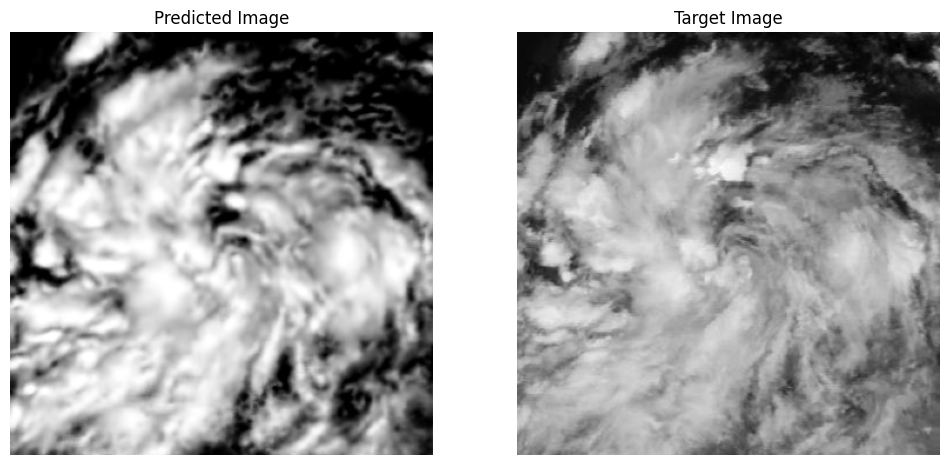

In [ ]:
model1.eval()
with torch.no_grad():
    test_x, target = next(iter(dataloader1))
    images = test_x['image'].to(device)  # 移动到相同的设备
    times = test_x['relative_time'].unsqueeze(-1).to(device)  # 同样移动到相同的设备

    pic = model1(images)

import matplotlib.pyplot as plt

predicted_image_np = pic.squeeze().cpu().numpy()
target_image_np = target[0].squeeze().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(predicted_image_np[0], cmap='gray')
axes[0].set_title('Predicted Image')
axes[0].axis('off')

axes[1].imshow(target_image_np, cmap='gray')
axes[1].set_title('Target Image')
axes[1].axis('off')

plt.show()

In [20]:
def test_model(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    losses = []  # Store losses for plotting

    with torch.no_grad():  # No need to track gradients
        for input_imgs, labels in dataloader:
            input_imgs, labels = input_imgs["image"].to(device), labels.to(device)

            outputs = model(input_imgs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

    # Calculate the average loss
    if len(losses) == 0:
        average_loss = 0.0
    else:
        average_loss = sum(losses) / len(losses)

    return average_loss


In [21]:
from torch.utils.data import DataLoader

stormtestloader = DataLoader(storm_test, batch_size=4,shuffle = False)
print(' Average ssmi losses' + str(test_model(model1,stormtestloader,criterion) ))

 Average ssmi losses0.5403198372750055


In [ ]:
torch.save(model1, 'model1_final.pth')

In [ ]:
model1 = None

In [ ]:
model2 = CNNLSTMModel()
model2.to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

In [ ]:
model2 = torch.load('model2_4storms.pth')

In [ ]:
storms = ['blq', 'dzw', 'eoi','fgi']

In [ ]:
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

In [ ]:
for storm in storms:
  dataset2 = StormDataset('/content/drive/MyDrive/Selected_Storms_curated/',storm,8, time_gap=2)
  dataloader2 = DataLoader(dataset1, batch_size=32, shuffle=False)
  train_model(model2, dataloader2, criterion, optimizer2, num_epochs=40)

Epoch 1/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.528]


Epoch 1/40, Loss: 0.6326


Epoch 2/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.529]


Epoch 2/40, Loss: 0.6278


Epoch 3/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.68it/s, loss=0.516]


Epoch 3/40, Loss: 0.6142


Epoch 4/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.68it/s, loss=0.512]


Epoch 4/40, Loss: 0.6083


Epoch 5/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.506]


Epoch 5/40, Loss: 0.6021


Epoch 6/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.501]


Epoch 6/40, Loss: 0.5964


Epoch 7/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.498]


Epoch 7/40, Loss: 0.5932


Epoch 8/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.496]


Epoch 8/40, Loss: 0.5907


Epoch 9/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.493]


Epoch 9/40, Loss: 0.5875


Epoch 10/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.492]


Epoch 10/40, Loss: 0.5850


Epoch 11/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.491]


Epoch 11/40, Loss: 0.5834


Epoch 12/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.488]


Epoch 12/40, Loss: 0.5821


Epoch 13/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.487]


Epoch 13/40, Loss: 0.5796


Epoch 14/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.485]


Epoch 14/40, Loss: 0.5782


Epoch 15/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.484]


Epoch 15/40, Loss: 0.5773


Epoch 16/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.483]


Epoch 16/40, Loss: 0.5755


Epoch 17/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.482]


Epoch 17/40, Loss: 0.5742


Epoch 18/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.482]


Epoch 18/40, Loss: 0.5728


Epoch 19/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.48]


Epoch 19/40, Loss: 0.5710


Epoch 20/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.479]


Epoch 20/40, Loss: 0.5700


Epoch 21/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.477]


Epoch 21/40, Loss: 0.5694


Epoch 22/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.475]


Epoch 22/40, Loss: 0.5686


Epoch 23/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.479]


Epoch 23/40, Loss: 0.5666


Epoch 24/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.479]


Epoch 24/40, Loss: 0.5679


Epoch 25/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.478]


Epoch 25/40, Loss: 0.5675


Epoch 26/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.475]


Epoch 26/40, Loss: 0.5681


Epoch 27/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.475]


Epoch 27/40, Loss: 0.5676


Epoch 28/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.472]


Epoch 28/40, Loss: 0.5635


Epoch 29/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.471]


Epoch 29/40, Loss: 0.5619


Epoch 30/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.469]


Epoch 30/40, Loss: 0.5614


Epoch 31/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.469]


Epoch 31/40, Loss: 0.5606


Epoch 32/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.469]


Epoch 32/40, Loss: 0.5609


Epoch 33/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.471]


Epoch 33/40, Loss: 0.5613


Epoch 34/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.474]


Epoch 34/40, Loss: 0.5624


Epoch 35/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.472]


Epoch 35/40, Loss: 0.5630


Epoch 36/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.482]


Epoch 36/40, Loss: 0.5695


Epoch 37/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.473]


Epoch 37/40, Loss: 0.5742


Epoch 38/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.472]


Epoch 38/40, Loss: 0.5750


Epoch 39/40: 100%|████████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=0.475]


Epoch 39/40, Loss: 0.5716


Epoch 40/40: 100%|█████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=0.47]

Epoch 40/40, Loss: 0.5664
Training complete


In [ ]:
torch.save(model2, 'model2_fianl.pth')

## Surprise Storm
When dealing with a new dataset, we incorporate all the information from the Surprise Storm into the network for one training session, allowing the model to learn its temporal patterns.
### Prediction strategy for the next three images.
If we use the predicted first and second images as input to predict the third image, the clarity of the third image will be poor. Therefore, we train two models: the first model uses images from i to i+sequence-1 to predict the i+sequence image, and the second model uses images from i to i+sequence-1 to predict the i+sequence+1 image. This way, we can use model1 to predict the first image and model2 to predict the second and third images. This approach results in better clarity for the generated third image.
<img src="./images/pic1.png">

In [ ]:
model1= torch.load('model1_final.pth')

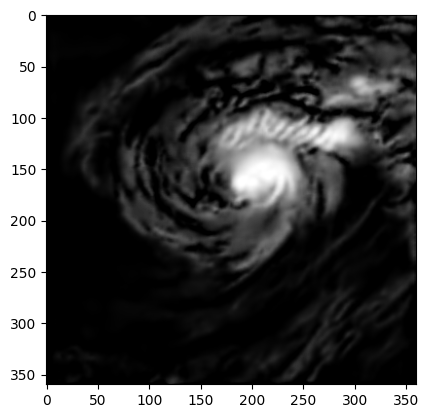

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def save_tensor_as_jpeg(tensor, filename):
    """Save tensor as a JPEG image, resized to 366x366."""
    to_pil = transforms.ToPILImage()
    resize = transforms.Resize((366, 366))  # Resize image to 366x366
    pil_img = to_pil(tensor.squeeze().byte())
    resized_img = resize(pil_img)  # Resize the image
    resized_img.save(filename)

def shift_images(images):
    """Shift image sequence forward by one"""
    for i in range(images.shape[1] - 1):
        images[0, i, :, :, :] = images[0, i + 1, :, :, :]
    images[0,-1,0,:,:] = images[0,-2,0,:,:]
    return images

def generate_future(future_step:int, dataset:StormDataset, model, gap = 1, seq = 8):
  cnt = len(dataset)
  full_inputs , _ = dataset[cnt - 1]
  last_idx = cnt - gap
  inputs, _ = dataset[last_idx]

  images = inputs['image'].detach().unsqueeze(0).to(device)
  full_images = full_inputs['image'].detach().unsqueeze(0).to(device)

  pre = full_images[0,-1,0,:,:]
  model.eval()
  if gap > 1:
    fig, axes = plt.subplots(1, gap, figsize=(12, 6))
  with torch.no_grad():
    images = images.to(device)
    # Initial update of the image sequence
    images = shift_images(images)
    for i in range(future_step):
      pic = model(images)
      # Convert to PIL Image
      to_pil = transforms.ToPILImage()
      pic = (pic + 1) /2 *255
      pil_img = to_pil(pic.squeeze().byte())
      # Save as JPEG
      filename = 'tst_' + str(cnt + i + seq + (0 if gap == 1 else gap-1)) + '.jpg'
      save_tensor_as_jpeg(pic, filename)

      pic = pic.squeeze().cpu().numpy()
      if gap > 1:
        axes[i].imshow(pic, 'gray')
        images[0,-1,0,:,:] = pre
        pre = torch.tensor(pic)
      else:
        plt.imshow(pic, 'gray')
        images[0,-1,0,:,:] = torch.tensor(pic)

      images = shift_images(images)
testset = StormDataset('/content/drive/MyDrive/ACS2/Surprise_Storm/','tst',8, time_gap=1)
generate_future(1, testset, model1)

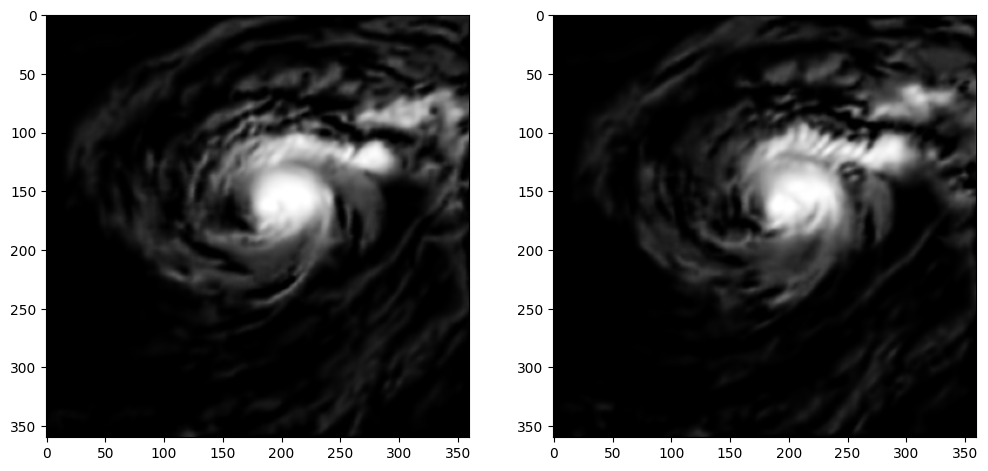

In [ ]:
generate_future(2, testset, model2, 2)